In [1]:
import os, sys, rdflib
import numpy as np, pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import rdflib.plugins.sparql as sparql
from SPARQLWrapper import SPARQLWrapper, JSON
sys.path.append(os.path.abspath("./util"))
from misc import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import plotly.plotly as py, plotly.graph_objs as go
from plotly.graph_objs import *

from sklearn import metrics
from hdbscan import HDBSCAN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering

In [2]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    dbpedia_type_graph = rdflib.Graph()
    dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
    dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 50.8 ms, sys: 15.2 ms, total: 66 ms
Wall time: 178 ms


In [3]:
%%time
# mapping freebase's mids to dbpedia's resources
mid2dbpedia = dict()
file_path = "./dataset/Release/freebase_code_names.txt"
with open(file_path, "r") as mapping_file:
    for line in mapping_file:
        mid, dbp_resource = line.replace("\n", "").split("\t")
        val = mid2dbpedia.get(mid, [])
        mid2dbpedia[mid] = val + [dbp_resource]

CPU times: user 305 ms, sys: 13.6 ms, total: 318 ms
Wall time: 332 ms


### Training the Model

In [4]:
walks_path = "./dataset/Release/ttl/embedding_5_7_train.ttl.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

418031

In [5]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    mid2types = dict()
    for uri in model.vocab:
        mid = uri.replace("http://rdf.freebase.com/ns", "")
        if mid in mid2dbpedia:
            dbpedia_eqs = [uri[1:-1] for uri in mid2dbpedia[mid]]
            mid_types = {row[0].n3() for uri in dbpedia_eqs for row in get_types(uri, dbpedia_type_graph)}
            if len(mid_types) > 0:
                mid2types[mid] = mid_types

    %store mid2types

CPU times: user 212 µs, sys: 14 µs, total: 226 µs
Wall time: 230 µs


In [6]:
mid_prefix = "http://rdf.freebase.com/ns"

embeds = np.asarray([model[mid_prefix + mid] for mid in mid2types])
mids   = np.asarray([mid for mid in mid2types])
labels = np.asarray([1 if is_person(mid, mid2types) else 0 for mid in mid2types])

random_idx  = np.random.choice(range(len(embeds)), len(embeds), replace=False)
split_point = len(embeds) * 70 / 100
training_idx, test_idx = random_idx[:split_point], random_idx[split_point:]

embeds_train, embeds_test = embeds[training_idx], embeds[test_idx]
mids_train,   mids_test   = mids[training_idx]  , mids[test_idx]
labels_train, labels_test = labels[training_idx], labels[test_idx]

ground_truth = get_ground_truth(mids, mid2types)

### Dimensionality reduction of embeddings

In [7]:
%%time
# embeddings = [model[uri] for uri in model.vocab]
# uris = [uri for uri in model.vocab]

tsne = TSNE(n_components=2)
%store -r twodims
if "twodims" not in locals():
    twodims = tsne.fit_transform(embeds)
    %store twodims

CPU times: user 940 µs, sys: 1.28 ms, total: 2.22 ms
Wall time: 1.82 ms


### Plot

In [17]:
colors = ["#FFEB3B" if is_agent(mid, mid2types) else "#F50057" for mid in mids]
scatter_data = scatter_plot(twodims, mids, colors=colors)
py.iplot(scatter_data, filename='Data')

Check it [here](https://plot.ly/create/?fid=chrispolo:1238)

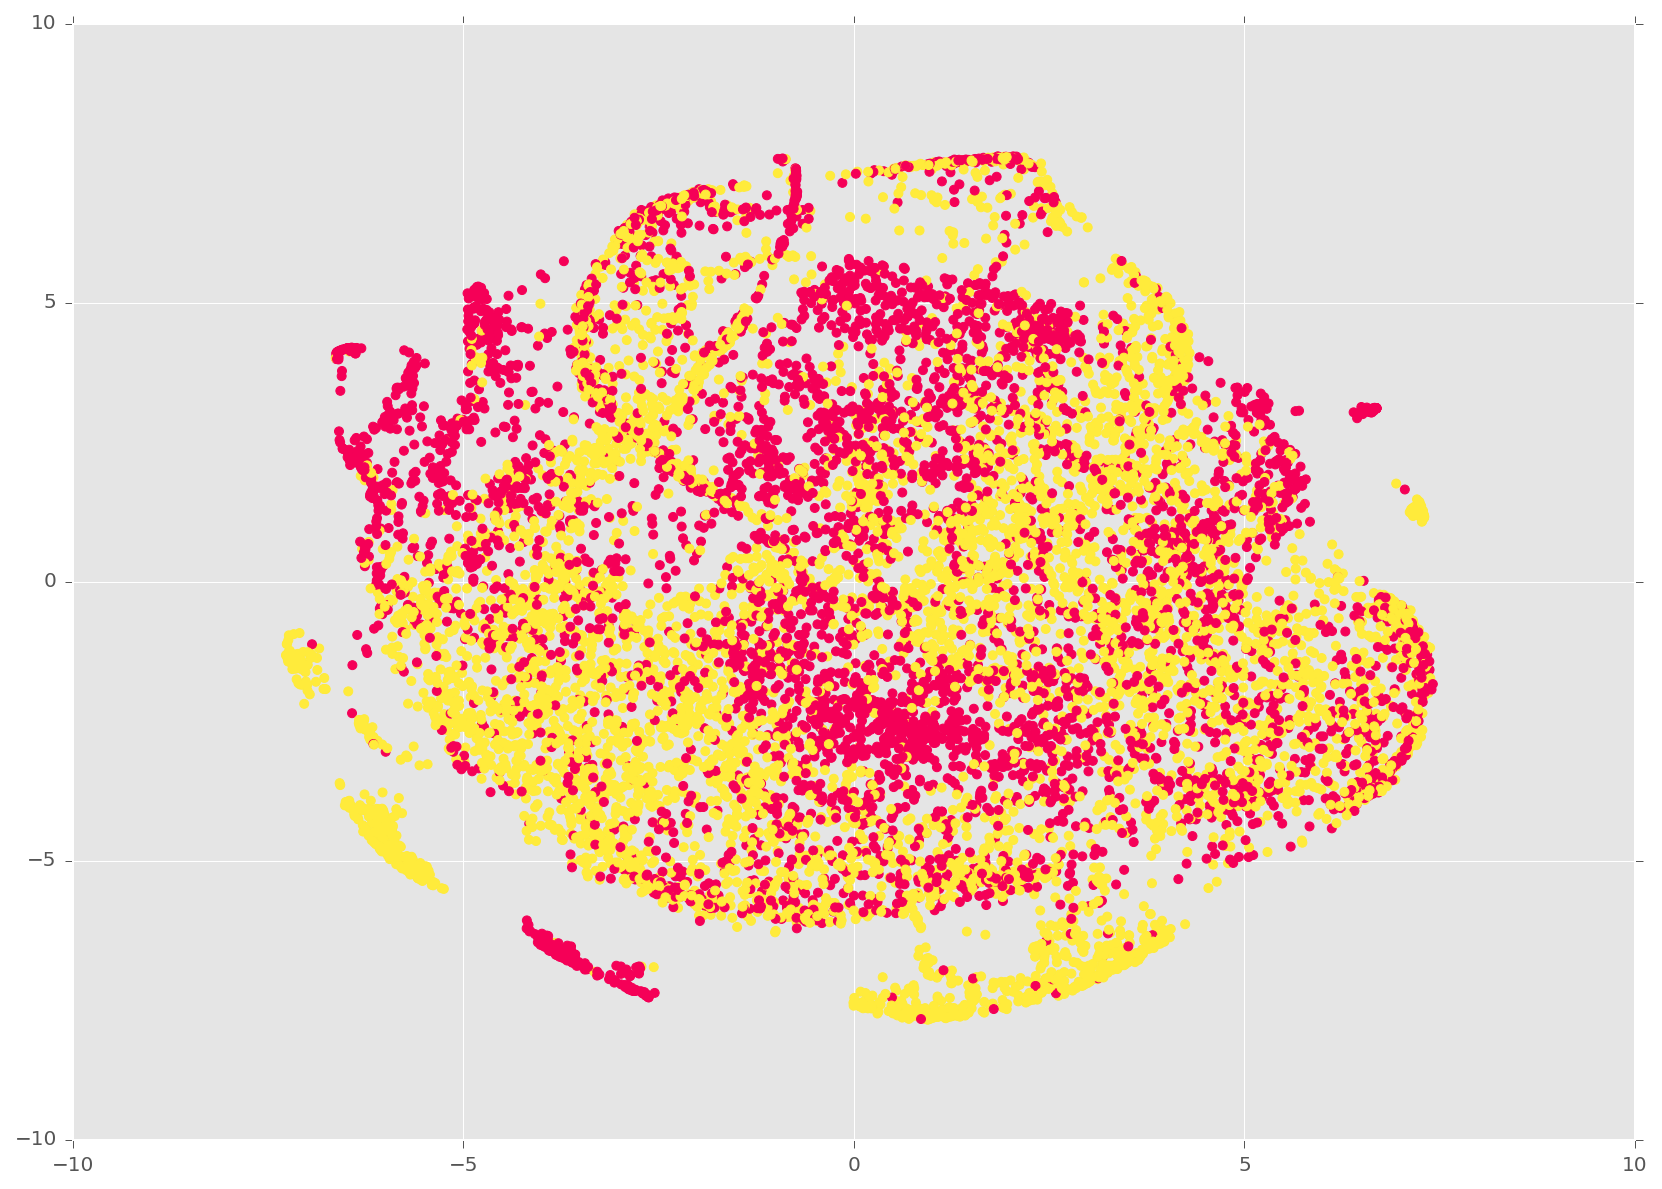

In [18]:
plt.rcParams["figure.figsize"] = [14, 10]
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=colors)
plt.show()

In [12]:
%%time
naive_bayes = GaussianNB()
rbf_svm     = SVC(gamma=2, C=1)
rand_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
ada_boost   = AdaBoostClassifier()

naive_bayes.fit(embeds_train, labels_train)
rbf_svm.fit(embeds_train, labels_train)
rand_forest.fit(embeds_train, labels_train)
ada_boost.fit(embeds_train, labels_train)

naive_bayes_pred = np.array([naive_bayes.predict([emb]) for emb in embeds_test])
rbf_svm_pred     = np.array([rbf_svm.predict([emb]) for emb in embeds_test])
rand_forest_pred = np.array([rand_forest.predict([emb]) for emb in embeds_test])
ada_boost_pred   = np.array([ada_boost.predict([emb]) for emb in embeds_test])

classifier = RandomForestClassifier(n_estimators=15)
classifier.fit(embeds_train, labels_train)
labels_pred = np.array([classifier.predict([emb]) for emb in embeds_test])

CPU times: user 26.9 s, sys: 162 ms, total: 27.1 s
Wall time: 27.5 s


In [14]:
metrics_df = pd.concat([
    binclass_metrics(labels_test, labels_pred, name="Random Forest"),
    binclass_metrics(labels_test, naive_bayes_pred, name="Naive Bayes"),
    binclass_metrics(labels_test, rbf_svm_pred, name="RBF SVM"),
    binclass_metrics(labels_test, ada_boost_pred, name="AdaBoost")
])

metrics_df

,Accuracy,Log-loss,Precision,Recall,F1-score,Matthews
Random Forest,0.827127,5.970877,0.798354,0.712711,0.753106,0.623129
Naive Bayes,0.543354,15.772337,0.444752,0.943424,0.604520,0.295864
RBF SVM,0.816798,6.327613,0.820130,0.646583,0.723090,0.598350
AdaBoost,0.819244,6.243138,0.779294,0.713446,0.744918,0.606783


Confusion matrix, without normalization


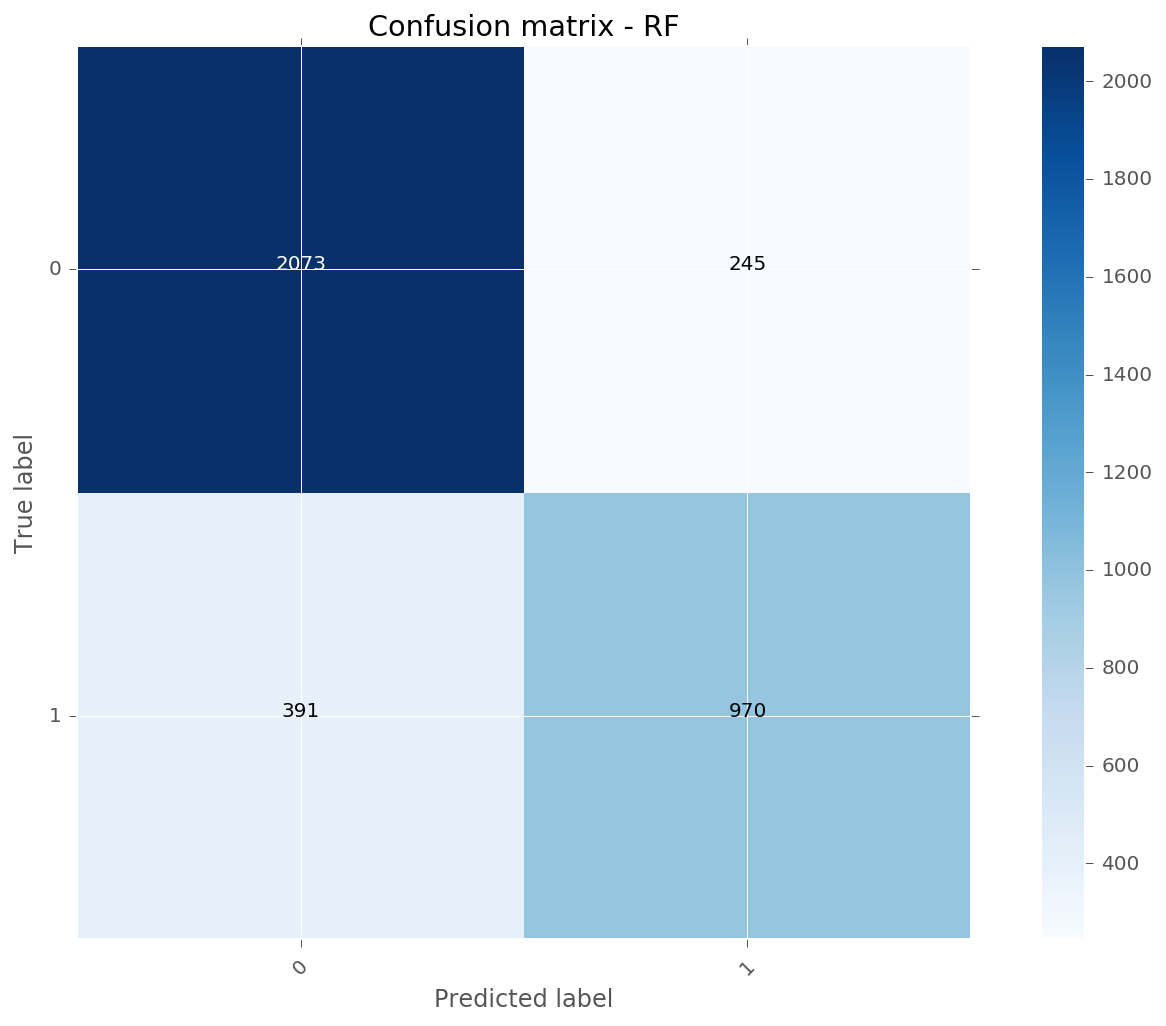

In [15]:
plt.rcParams["figure.figsize"] = [10, 7]

cnf_matrix = metrics.confusion_matrix(labels_test, labels_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix - RF')
plt.show()